In [32]:
import os
import yaml
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from glob import glob
from tqdm import tqdm
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from albumentations.core.composition import Compose, OneOf

# from train import train, validate
# from source.network import UNetPP
# from source.dataset import DataSet

ModuleNotFoundError: No module named 'train'

In [2]:
import os
import cv2
import numpy as np
import torch.utils.data


class DataSet(torch.utils.data.Dataset):
    def __init__(self, img_ids, img_dir, mask_dir, img_ext, mask_ext, transform=None):
        self.img_ids = img_ids
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_ext = img_ext
        self.mask_ext = mask_ext
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]

        img = cv2.imread(os.path.join(self.img_dir, img_id + self.img_ext))

        mask = []
        mask.append(cv2.imread(os.path.join(self.mask_dir,
                                            img_id + self.mask_ext), cv2.IMREAD_GRAYSCALE)[..., None])
        mask = np.dstack(mask)

        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        img = img.astype('float32') / 255
        img = img.transpose(2, 0, 1)
        mask = mask.astype('float32') / 255
        mask = mask.transpose(2, 0, 1)

        return img, mask, {'img_id': img_id}



In [3]:
import torch
from torch import nn


class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out


class UNetPP(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output


In [4]:
import torch


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)


In [5]:
import os
import yaml
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from glob import glob
from tqdm import tqdm
from collections import OrderedDict
from ML_Pipeline.utils import iou_score, AverageMeter
from albumentations import Resize
from albumentations.augmentations import transforms
from sklearn.model_selection import train_test_split
from albumentations.core.composition import Compose, OneOf
from albumentations.augmentations.geometric.rotate import RandomRotate90
from ML_Pipeline.network import UNetPP
from ML_Pipeline.dataset import DataSet


def train(deep_sup, train_loader, model, criterion, optimizer):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    model.train()

    pbar = tqdm(total=len(train_loader))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for input, target, _ in train_loader:
        input = input.to(device)
        target = target.to(device)

        # compute output
        if deep_sup:
            outputs = model(input)
            loss = 0
            for output in outputs:
                loss += criterion(output, target)
            loss /= len(outputs)
            iou = iou_score(outputs[-1], target)
        else:
            output = model(input)
            loss = criterion(output, target)
            iou = iou_score(output, target)

        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_meters['loss'].update(loss.item(), input.size(0))
        avg_meters['iou'].update(iou, input.size(0))

        postfix = OrderedDict([
            ('loss', avg_meters['loss'].avg),
            ('iou', avg_meters['iou'].avg),
        ])
        pbar.set_postfix(postfix)
        pbar.update(1)
    pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])


def validate(deep_sup, val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    # switch to evaluate mode
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        pbar = tqdm(total=len(val_loader))
        for input, target, _ in val_loader:
            input = input.to(device)
            target = target.to(device)

            # compute output
            if deep_sup:
                outputs = model(input)
                loss = 0
                for output in outputs:
                    loss += criterion(output, target)
                loss /= len(outputs)
                iou = iou_score(outputs[-1], target)
            else:
                output = model(input)
                loss = criterion(output, target)
                iou = iou_score(output, target)

            avg_meters['loss'].update(loss.item(), input.size(0))
            avg_meters['iou'].update(iou, input.size(0))

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)
        pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])


In [6]:
import cv2
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt

from ML_Pipeline.network import UNetPP
from argparse import ArgumentParser
from albumentations.augmentations.geometric import resize
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose


val_transform = Compose([
    resize.Resize(256, 256),
    transforms.Normalize(),
])


def image_loader(image_name):
    img = cv2.imread(image_name)
    img = val_transform(image=img)["image"]
    img = img.astype('float32') / 255
    img = img.transpose(2, 0, 1)

    return img

In [8]:
with open("config.yaml") as f:
    config = yaml.load(f, Loader=yaml.Loader)

extn = config["extn"]
epochs = config["epochs"]
log_path = config["log_path"]
mask_path = config["mask_path"]
image_path = config["image_path"]
model_path = config["model_path"]

## Create log file

In [9]:
log = OrderedDict([
    ('epoch', []),
    ('loss', []),
    ('iou', []),
    ('val_loss', []),
    ('val_iou', []),
])

best_iou = 0
trigger = 0

## Split images into train and validation set

In [10]:
extn_ = f"*{extn}"
img_ids = glob(os.path.join(image_path, extn_))
img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_ids]
train_img_ids, val_img_ids = train_test_split(img_ids, test_size=0.2)

## Define data transformations

In [11]:
from albumentations.augmentations.geometric import rotate
from albumentations.augmentations import geometric
train_transform = Compose([
    rotate.RandomRotate90(),
    geometric.transforms.Flip(),
    OneOf([
        transforms.HueSaturationValue(),
        transforms.RandomBrightnessContrast()
    ], p=1),
    resize.Resize(256, 256),
    transforms.Normalize(),
])

val_transform = Compose([
    resize.Resize(256, 256),
    transforms.Normalize(),
])

## Create train and validation dataset

In [12]:
train_dataset = DataSet(
    img_ids=train_img_ids,
    img_dir=image_path,
    mask_dir=mask_path,
    img_ext=extn,
    mask_ext=extn,
    transform=train_transform)

val_dataset = DataSet(
    img_ids=val_img_ids,
    img_dir=image_path,
    mask_dir=mask_path,
    img_ext=extn,
    mask_ext=extn,
    transform=val_transform)

## Create train and validation data loaders

In [13]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    drop_last=False)

## Create the model object

In [14]:
# Create model object
model = UNetPP(1, 3, True)

# Port model to GPU if it is available
if torch.cuda.is_available():
    model.cuda()
    
# Define Loss Function
criterion = nn.BCEWithLogitsLoss()
params = filter(lambda p: p.requires_grad, model.parameters())

# Define Optimizer
optimizer = optim.Adam(params, lr=1e-3, weight_decay=1e-4)

## Run the train loop

In [16]:
for epoch in range(epochs):
    print(f'Epoch [{epoch}/{epochs}]')

    # train for one epoch
    train_log = train(True, train_loader, model, criterion, optimizer)
    # evaluate on validation set
    val_log = validate(True, val_loader, model, criterion)

    print('loss %.4f - iou %.4f - val_loss %.4f - val_iou %.4f'
              % (train_log['loss'], train_log['iou'], val_log['loss'], val_log['iou']))

    log['epoch'].append(epoch)
    log['loss'].append(train_log['loss'])
    log['iou'].append(train_log['iou'])  
    log['val_loss'].append(val_log['loss'])
    log['val_iou'].append(val_log['iou'])

    pd.DataFrame(log).to_csv(log_path, index=False)

    trigger += 1

    if val_log['iou'] > best_iou:
        torch.save(model.state_dict(), model_path)
        best_iou = val_log['iou']
        print("=> saved best model")
        trigger = 0

Epoch [0/1]


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 8/8 [05:25<00:00, 40.72s/it, loss=0.492, iou=9.98e-11]


loss 0.5498 - iou 0.0857 - val_loss 0.4922 - val_iou 0.0000
=> saved best model


In [15]:
import cv2
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt

from ML_Pipeline.predict import image_loader
from ML_Pipeline.network import UNetPP
from argparse import ArgumentParser
from albumentations.core.composition import Compose

%matplotlib inline

## Create validation transforms

In [16]:
val_transform = Compose([
    resize.Resize(256, 256),
    transforms.Normalize(),
])

In [17]:
with open("config.yaml") as f:
    config = yaml.load(f, Loader=yaml.Loader)

In [18]:
im_width = config["im_width"]
im_height = config["im_height"]
model_path = config["model_path"]
output_path = config["output_path"]

## Load the model

In [19]:
# Create model object
model = UNetPP(1, 3, True)

# Load pre-trained weights
model.load_state_dict(torch.load(model_path))

# Port the model to GPU if it is available
if torch.cuda.is_available():
    model.cuda()
    
# Set model mode to evaluation
model.eval()

UNetPP(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (c

## Load the test image

In [20]:
test_img = "../input/PNG/Original/116.png"
image = image_loader(test_img)

# Convert the image to a batch of 1 image
image = np.expand_dims(image,0)

# Convert numpy array to torch tensor
image = torch.from_numpy(image)

In [21]:
# Port the image to GPU if it is available
if torch.cuda.is_available():
    image = image.to(device="cuda")

## Make prediction

In [30]:
mask = model(image)

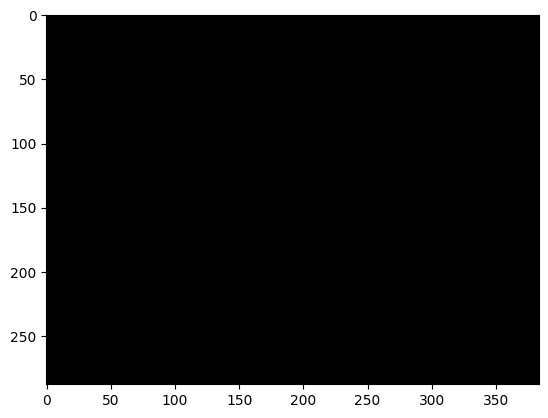

In [31]:
mask = mask[-1]

# Convert torch tensor to numpy array
mask = mask.detach().cpu().numpy()

# Convert output to a 2-d array
mask = np.squeeze(np.squeeze(mask, axis=0), axis=0)

# Convert output to binary based on threshold
mask[mask > -2.5] = 255
mask[mask <= -2.5] = 0

# Resize the ouptut image to input image size
mask = cv2.resize(mask, (im_width, im_height))

# Plot the generated mask
plt.imshow(mask, cmap="gray")

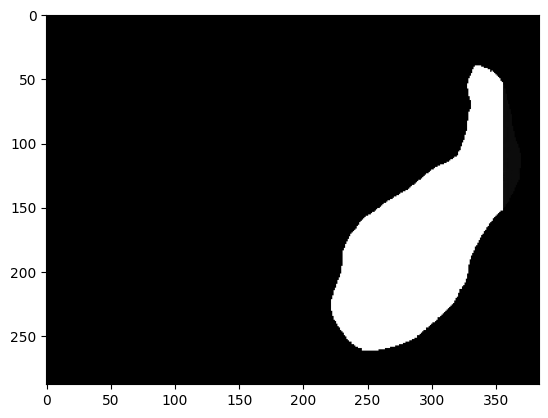

In [37]:
actual_mask = "../input/PNG/Ground Truth/106.png"
am = plt.imread(actual_mask)
plt.imshow(am, cmap="gray")